# **A quantum GAN algorithm**
***Application to SVI volatility smile***
---
 <br>
 
- Copyright (c) Assouel-Jacquier-Kondratyev, 2021. All rights reserved

- Authors: <amine.assouel@ens-paris-saclay.fr>, <a.jacquier@imperial.ac.uk>,  <a.kondratyev@imperial.ac.uk>

- Reference paper: "A Quantum Generative Adversarial Network for distributions" <https://arxiv.org/abs/2110.02742>

- Platform: Tested on Windows 10 with Python 3.7

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# SVI Parameterisation

The [SVI parameterisation](http://faculty.baruch.cuny.edu/jgatheral/madrid2004.pdf) assumes the following parametric form for the total implied variance:
$$
\omega_{\mathrm{SVI}}(x,T) := \sigma_{\mathrm{SVI}}(x,t)^2 T
 = a + b\left(\rho(x-m)+\sqrt{(x-m)^2+\sigma^2}\right),
$$
where $x\in\mathbb{R}$ denotes the log-moneyness, $T\geq 0$ is the maturity and $a, b, \rho, m, \sigma$ are parameters. 

**Note:** The maturity $T$ is fixed throughout and we therefore omit it in the notations and in the code from now one, writing $\omega_{\mathrm{SVI}}(x) = \omega_{\mathrm{SVI}}(x,T)$.

### Density

For the given fixed time horizon $T$, the density of the log-stock price corresponding to the SVI smile is given explictly as
$$
p(x) = \frac{g(x)}{\sqrt{2\pi \omega_{\mathrm{SVI}}(x)}}\exp\left\{-\frac{d_{-}\left(x, \omega_{\mathrm{SVI}}(x)\right)^2}{2}\right\},
$$
where
$$
d_{-}(x,\omega) := -\frac{x}{\sqrt{\omega_{\mathrm{SVI}}(x))}} - \frac{\sqrt{\omega_{\mathrm{SVI}}(x))}}{2}
$$
and
$$
g(x,\omega_{\mathrm{SVI}}(x))) :=
\left(1-\frac{x\omega_{\mathrm{SVI}}'(x)}{2\omega_{\mathrm{SVI}}(x)}\right)^2
-\frac{\omega_{\mathrm{SVI}}'(x)^2}{4}\left(\frac{1}{4}+\frac{1}{\omega_{\mathrm{SVI}}(x)}\right)
+\frac{\omega_{\mathrm{SVI}}''(x)}{2},
$$
where all the derivatives are with respect to $x$.

#### No arbitrage

One of the key conditions for the SVI parameterisation to be realistic is the so-called *Absence of Butterfly arbitrage*, namely that the density $p(\cdot)$ must be non-negative everywhere. We refer the reader to 
'Arbitrage-free SVI volatility surfaces' (J. Gatheral and A. Jacquier, 2014) for full details.

In [2]:
class Svi():
    ## SVI parameterisation for the total implied variance
    
    def __init__(self, sviparams):
        a, b, rho, m, sigma = sviparams
        self.a = a
        self.b = b
        self.rho = rho
        self.m = m
        self.sigma = sigma
        self.sigma2 = self.sigma*self.sigma
        
    def sviTotalVariance(self, x):
        ### Total implied variance in SVI
        ### xx is a numpy array
        return self.a + self.b*(self.rho*(x-self.m) + np.sqrt((x-self.m)*(x-self.m) + self.sigma2))
        
    def sviSmileVar(self, xx):
        ### Total implied variance in SVI
        return [self.sviTotalVariance(x) for x in xx]
    
    def sviSmileVol(self, xx):
        ### Implied volatility in SVI
        ### xx is a numpy array
        return np.array([np.sqrt(self.sviTotalVariance(x)) for x in xx])
    
    def firstDeriv(self, x):
    ## First derivative of sviTotalVariance with respect to x
        xm = x-self.m
        return self.b*(self.rho*np.sqrt(xm*xm+self.sigma2)+xm)/(np.sqrt(xm*xm+self.sigma2))

    def secondDeriv(self, x):
    ## Second derivative of sviTotalVariance with respect to x
        xm = x-self.m
        return self.b*self.sigma2 / (np.sqrt(xm*xm+self.sigma2)*(xm*xm+self.sigma2))
    
    
    def g(self, x):
        ### Function g()
        w = self.sviTotalVariance(x)
        w1 = self.firstDeriv(x)
        w2 = self.secondDeriv(x)
        return (1. - 0.5*x*w1/w) * (1. - 0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    
    def dminus(self, x):
        ### Function d_{-}
        vsqrt = np.sqrt(self.sviTotalVariance(x))
        return -x/vsqrt - 0.5*vsqrt
    
    def density(self, x):
        ### SVI density of the log-stock price
        dm = self.dminus(x)
        return self.g(x)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*self.sviTotalVariance(x))
    
    def densityVec(self, xx):
        ### SVI density of the log-stock price
        ### xx is a numpy array
        return np.array([self.density(x) for x in xx])
    
    def plotDensityandSmile(self, xx):
        zeroLine = np.linspace(0., 0., len(xx))
        densityPlot = self.densityVec(xx)

        plt.figure(figsize=(12,8)) # make separate figure

        plt.rcParams["figure.figsize"] = [12, 10]
        plt.subplot(2, 2, 1)   # creates the first plot on 2 by 2 table
        plt.plot(xx, densityPlot, 'b', linewidth = 2)
        plt.plot(xx, zeroLine, 'k', linewidth = 2)
        plt.title('SVI implied density', fontsize=12)
        plt.xlabel(u'log-moneyness', fontsize=12)
        plt.fill_between(xx, densityPlot, zeroLine, where=densityPlot<zeroLine, facecolor='yellow', interpolate=True)

        print( "Check that the density integrates to unity: ", np.round(quad(lambda x: self.density(x), -40., 40., epsrel=1.49e-15, limit=200)[0], 4))
        plt.subplot(2, 2, 2)   # creates the first plot on 2 by 2 table
        plt.plot(xx, self.sviSmileVol(xx), 'b', linewidth = 2)
        plt.title('SVI implied volatility smile', fontsize=12)
        plt.xlabel(u'log-moneyness', fontsize=12)
        plt.show()

## Examples

In [3]:
a, b, rho, m, sigma = 0.030358, 0.0503815, -0.1, 0.3, 0.048922

sviparams = a, b, rho, m, sigma
sviparams_bumped = a, b, rho, m, 3.*sigma

svi = Svi(sviparams)
svi_bumped = Svi(sviparams_bumped)

xx = np.linspace(-1., 1., 100)

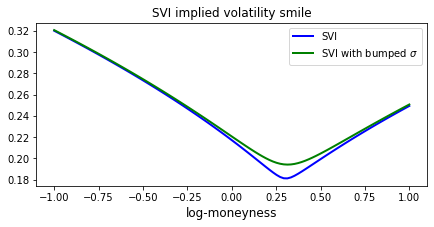

In [4]:
plt.figure(figsize=(7,3))
plt.plot(xx, svi.sviSmileVol(xx), 'b', linewidth=2, label="SVI")
plt.plot(xx, svi_bumped.sviSmileVol(xx), 'g', linewidth=2, label="SVI with bumped $\sigma$")
plt.title("SVI implied volatility smile")
plt.xlabel("log-moneyness", fontsize=12)
plt.legend()
plt.show()

Check that the density integrates to unity:  1.0


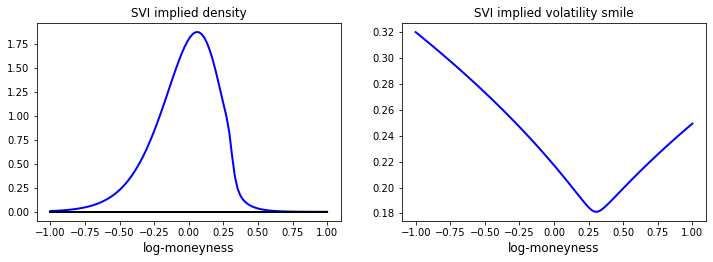

In [5]:
svi.plotDensityandSmile(xx)

## Discretisation of the SVI distribution

Since Quantum Computing works on discrete distributions, we first need to discretise the SVI density above.
We consider $2^{\textrm{NBQUBITS}}$ points.
Note: for now, the algorithm is written for a 4-qubit system, so this cannot be modified here.

In [6]:
NBQUBITS = 4

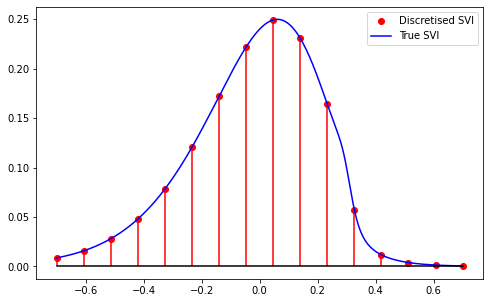

In [7]:
nbPoints = 2**NBQUBITS
xx = np.linspace(-.7,.7,nbPoints)
XSmile = np.linspace(min(xx),max(xx),1000)

sviSmile = svi.densityVec(XSmile)*2/(2**NBQUBITS-1)
state = svi.densityVec(xx)*2/(2**NBQUBITS-1)

plt.figure(figsize=(8,5))
plt.plot(xx,state, 'ro', label="Discretised SVI")
plt.plot(XSmile,sviSmile, 'b', label="True SVI")
plt.plot(xx, xx*0., 'k')
plt.legend(loc="best")
for (i,x) in enumerate(xx):
    plt.vlines(x, 0., state[i], colors='r', linestyles='solid')
plt.show()

Normalised state that will be used as target distribution

In [8]:
state = state / np.sum(state)

# QUANTUM CIRCUITS

In [9]:
#initialisation
from mpl_toolkits import mplot3d
plt.style.use('ggplot')

# importing Qiskit
from qiskit import *
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Operator
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
import pylatexenc
# import basic plot tools
from qiskit.visualization import plot_histogram

#Simulation
BACKEND = QasmSimulator()

#### Inverse Quantum Fourier Transform 
Source: https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html


In [10]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

# Quantum Circuit for the Discriminator

In [11]:
class Qdiscriminator():
    
    def __init__(self, num_ancillas, nbQubits, init_state): 
        """
        num_ancillas: number of ancilla qubits
        nbQubits: number of qubits
        init_state: initial discrete distribution
        """
        
        self.num_ancillas = num_ancillas
        self.nbQubits = nbQubits
        self.RealState = [np.sqrt(a) for a in init_state] ##  wave function encoding the initial distribution
        self.total = 2*self.num_ancillas + self.nbQubits ## Total number of qubits in the circuit
        self.epsilon = 1/2 ## for the sign of the inner product
        self.w = np.random.uniform(-1,1,self.nbQubits) ## Initialisation of the weights for the inner product
        
        def sigm(x): ## Sigmoid activation function
            return 1./(1.+np.exp(-x))
        
        z = 5 ## Free parameter
        
        self.Sigmoid = Operator([[1,0,0,0],[0,np.exp(2*1.j*np.pi*sigm(z)/2),0,0],
                                 [0,0,1,0],[0,0,0,np.exp(2*1.j*np.pi*sigm(-z)/2)]]) ## Operator associated to the sigmoid activation function
        
        self.Qsigmoid = self.QSigmoid() ## initialise the quantum circuit

        
    def innerProd(self, ww):
        """
        Inner product function
        ## ww: weights
        """
        qc = QuantumCircuit(self.num_ancillas+self.nbQubits)
        for i in range(self.num_ancillas):
            qc.h(i)

        qcint = QuantumCircuit(1+self.nbQubits)
        for l in range(self.nbQubits):
            for k in range(1):
                qcint.cp(self.epsilon*2*np.pi*ww[l]/(2**(self.num_ancillas+k+1)),0,1+l+k)

        P = Operator(qcint)

        for i in range(self.num_ancillas):
            Gate = UnitaryGate(P**(i+1),'$U_{w,1}$')
            T = [i]+[k for k in range(self.num_ancillas,self.nbQubits+self.num_ancillas)]
            qc = qc.compose(Gate,T)

        qft_dagger(qc, self.num_ancillas)

        return qc
        
        
    
    
    def QSigmoid(self):  
        """
        Constructs the circuit corresponding to the sigmoid activation function
        """
        
        qc = QuantumCircuit(2*self.num_ancillas)

        for i in range(self.num_ancillas):
            qc.h(i)

        for i in range(self.num_ancillas):
            R = UnitaryGate(self.Sigmoid**(i+1),'Sigmoid')
            qc = qc.compose(R,[i]+[k for k in range(self.num_ancillas,2*self.num_ancillas)])

        qft_dagger(qc,self.num_ancillas)

        return qc
    
    
    def Building(self, state, ww):
        """
        Builds the whole quantum circuit
        """
        
        qi = QuantumCircuit(self.nbQubits)   #initialising circuit
        qi.initialize(self.RealState, range(self.nbQubits))
        Q = QuantumCircuit(self.total,1+self.nbQubits)
        Q = Q.compose(qi,[k for k in range(2,self.total)]) 
        Q = Q.compose(self.innerProd(ww),[i for i in range(1,self.total)])
        Q = Q.compose(self.Qsigmoid,[0,1])
        Q.measure(0,0)

        for k in range(self.nbQubits):
            Q.measure(2+k,1+k)

        return Q   
    
    def BuildingNoMeasurements(self, ww):
        """
        Builds the whole quantum circuit without the measuring canal
        """
        
        Q = QuantumCircuit(self.total)
        Q = Q.compose(self.innerProd(ww),[i for i in range(1,self.total)])
        Q = Q.compose(self.Qsigmoid,[0,1])
        
        return Q 
    
    
    def cost(self, FakeState, ww, num_shots):
        """
        Estimation of the cost of the circuit run with num_shots amount of shots.
        FakeState: quantum version of a distribution as generator (for example) by a generator
        """
        
        QR = self.Building(self.RealState, ww)
        QF = self.Building(FakeState, ww)

        qc_compiled_Real = transpile(QR,BACKEND)
        job_sim_Real = BACKEND.run(QR, shots=num_shots)
        result_sim_Real = job_sim_Real.result()
        counts_Real = result_sim_Real.get_counts(QR)

        qc_compiled_Fake = transpile(QF,BACKEND)
        job_sim_Fake = BACKEND.run(QF, shots=num_shots)
        result_sim_Fake = job_sim_Fake.result()
        counts_Fake = result_sim_Fake.get_counts(QF)

        ptrue = [str(g) + str(i) + str(j) + str(k) + str(1) for g in range(2) for i in range(2) for j in range(2) for k in range(2)]
        ## ptrue corresponds to the R_T region
        
        C_Real, C_Fake = 0, 0

        for a in list(counts_Real.keys()):
            if a in ptrue:
                C_Real += counts_Real.get(a)

        for i in list(counts_Fake.keys()):
            if i in ptrue:
                C_Fake += counts_Fake.get(i)

        return  (C_Real/num_shots - C_Fake/num_shots)/2.
    
    
    def derivative(self, i, FakeState, num_shots):
        """
        Computes the derivative of cost function with respect to the weight
        #num_shots: number of shots to run the circuits
        """
        
        W_p = self.w.copy()
        W_m = self.w.copy()
        W_p[i] += 2  #it was +2pi
        W_m[i] -= 2 #it was -2pi
        C_p = cost(FakeState, W_p, num_shots[i])
        C_m = cost(FakeState, W_m, num_shots[i])

        return (C_p - C_m) / 2.

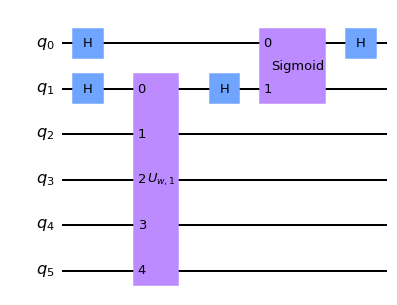

In [12]:
num_ancillas = 1 ## The number of ancillas is fixed in this setting.

qdiscrim = Qdiscriminator(num_ancillas, NBQUBITS, state)

qdiscrim.BuildingNoMeasurements(qdiscrim.w).draw('mpl')

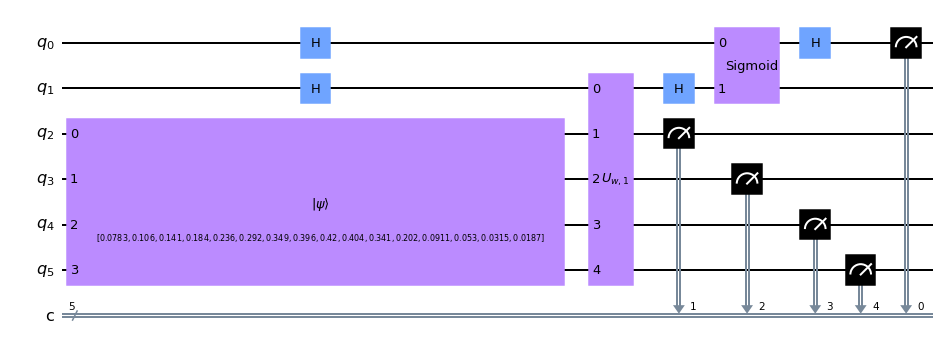

In [13]:
qdiscrim.Building(qdiscrim.RealState, qdiscrim.w).draw('mpl')

# Quantum Circuit for the Generator

In [14]:
from qiskit.circuit.library import RXXGate
from qiskit.circuit.library import RYYGate
from qiskit.circuit.library import CRXGate
from qiskit.circuit.library import CRYGate

In [15]:
class Qgenerator():
    """
    Construction of the quantum circuit for the generator, given a discriminator
    """
    
    def __init__(self, qdiscrim):
        """
        qdiscrim: Quantum discriminator
        shots: number of shots to run the quantum generator
        """
        self.qdiscrim = qdiscrim
        
        self.num_qubitsG = self.qdiscrim.nbQubits ## Same number of qubits between the generator and the discriminator
        self.nbThetas = 9 ## Represent the number of rotation parameters. Our structure is fixed to 9.
        self.thetas = np.random.uniform(-np.pi,np.pi,self.nbThetas) ## Rotation parameters
        
        self.shots = 2**10   # number of shots to compute the metrics
        self.indexes = [str(h)+str(i)+str(j)+str(k) for h in range(2) for i in range(2) for j in range(2) for k in range(2)]
        
        self.num_shots_DerivThetas = [2**17 for k in range(self.nbThetas)]
        self.w = qdiscrim.w
        
        
    def BuildingG(self):
        """
        Builds the quantum circuit for the generator
        """
    
        Gen = QuantumCircuit(self.num_qubitsG,self.num_qubitsG)
        Gen.ry(self.thetas[0],3)
        Gen = Gen.compose(CRYGate(self.thetas[1]),(3,2))
        Gen.x(3)
        Gen = Gen.compose(CRYGate(self.thetas[2]),(3,2))
        Gen.x(3)
        Gen.ry(self.thetas[3],0)
        Gen.ry(self.thetas[4],1)
        Gen = Gen.compose(CRXGate(self.thetas[5]),(0,1))
        Gen = Gen.compose(CRXGate(self.thetas[6]),(1,0))
        Gen.ry(self.thetas[7],0)
        Gen.ry(self.thetas[8],1)

        for r in range(self.num_qubitsG):
            Gen.measure(r,r)
            
        return Gen
    
    
    def Building_Gen_Discrim(self, th, ww):
        """
        Combine both circuits of the discriminator and the generator
        ### th: vector of parameters theta
        ### ww: vector of weights
        """

        Q = QuantumCircuit(self.num_qubitsG + 2*self.qdiscrim.num_ancillas, 5)

        Gen = QuantumCircuit(self.num_qubitsG,self.num_qubitsG)
        Gen.ry(th[0],3)
        Gen = Gen.compose(CRYGate(th[1]),(3,2))
        Gen.x(3)
        Gen = Gen.compose(CRYGate(th[2]),(3,2))
        Gen.x(3)
        Gen.ry(th[3],0)
        Gen.ry(th[4],1)
        Gen = Gen.compose(CRXGate(th[5]),(0,1))
        Gen = Gen.compose(CRXGate(th[6]),(1,0))
        Gen.ry(th[7],0)
        Gen.ry(th[8],1)

        Q = Q.compose(Gen,[k for k in range(2,6)])

        Q = Q.compose(self.qdiscrim.innerProd(ww),[i for i in range(1,6)])
        Q = Q.compose(self.qdiscrim.Qsigmoid,[0,1])
        Q.measure(0,0)

        for k in range(4):
            Q.measure(2+k,1+k)

        return Q
    
    def state_distribG(self, nbShots):
        """
        Generates a discrete distribution running the circuit nbShots time
        """
        
        Gen = self.BuildingG()
        job = execute(Gen, BACKEND, shots=nbShots)
        countsG = job.result().get_counts(Gen)
        StateG = []

        for a in self.indexes:
            if a in list(countsG.keys()):
                StateG.append(countsG.get(a)/nbShots)
            else:
                StateG.append(0.)

        return StateG
    

    def costGen_theta(self, num_shots_DerivThetas, th):
        """
        Similar to the version in the quantum discriminator
        Computes the cost running the circuit
        """

        Q_real = qdiscrim.Building(self.qdiscrim.RealState, self.qdiscrim.w)
        Q_fake = self.Building_Gen_Discrim(th, self.qdiscrim.w)
     
        job_real = execute(Q_real, BACKEND, shots=num_shots_DerivThetas)
        counts_real = job_real.result().get_counts(Q_real) 

        job_fake = execute(Q_fake, BACKEND, shots=num_shots_DerivThetas)
        
        counts_fake = job_fake.result().get_counts(Q_fake)

        ptrue=[str(g)+str(i)+str(j)+str(k)+str(1) for g in range(2) for i in range(2) for j in range(2) for k in range(2)]

        C_real, C_fake = 0, 0

        for a in list(counts_real.keys()):
            if a in ptrue:
                C_real += counts_real.get(a)

        for i in list(counts_fake.keys()):
            if i in ptrue:
                C_fake += counts_fake.get(i)

        return (C_real/num_shots_DerivThetas - C_fake/num_shots_DerivThetas)/2.
    

    def costGen_w(self, numShots_Deriv_w, ww):
        """
        Similar to the version in the quantum discriminator
        Computes the cost running the circuit
        """

        Q_real = qdiscrim.Building(self.qdiscrim.RealState, ww)
        Q_fake = self.Building_Gen_Discrim(self.thetas, ww)
     
        job_real = execute(Q_real, BACKEND, shots=numShots_Deriv_w)
        counts_real = job_real.result().get_counts(Q_real) 

        job_fake = execute(Q_fake, BACKEND, shots=numShots_Deriv_w)
        
        counts_fake = job_fake.result().get_counts(Q_fake)

        ptrue=[str(g)+str(i)+str(j)+str(k)+str(1) for g in range(2) for i in range(2) for j in range(2) for k in range(2)]

        C_real, C_fake = 0, 0

        for a in list(counts_real.keys()):
            if a in ptrue:
                C_real += counts_real.get(a)

        for i in list(counts_fake.keys()):
            if i in ptrue:
                C_fake += counts_fake.get(i)

        return (C_real/numShots_Deriv_w - C_fake/numShots_Deriv_w)/2.
        
    
    def derivativeGen_theta(self, i, shots): 
        """
        Derivative with respect to theta
        """
        T_p = self.thetas.copy()
        T_m = self.thetas.copy()

        T_p[i] += np.pi/2  #it is pi/2 because no epsilon=1/2 here
        T_m[i] -= np.pi/2 #same here

        C_p = self.costGen_theta(shots[i], T_p)
        C_m = self.costGen_theta(shots[i], T_m)

        return ((C_p - C_m)/2)

    
    def derivativeGen_w(self, i, shots):
        """
        Derivative with respect to w
        """
        W_p = self.qdiscrim.w.copy()
        W_m = self.qdiscrim.w.copy()
        W_p[i] += 2  #real value used is 2
        W_m[i] -= 2 #same here
        C_p = self.costGen_w(shots[i], W_p)
        C_m = self.costGen_w(shots[i], W_m)

        return ((C_p - C_m)/2)

In [16]:
qgen = Qgenerator(qdiscrim)

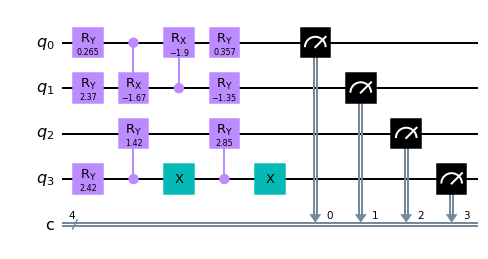

In [17]:
qgen.BuildingG().draw('mpl')

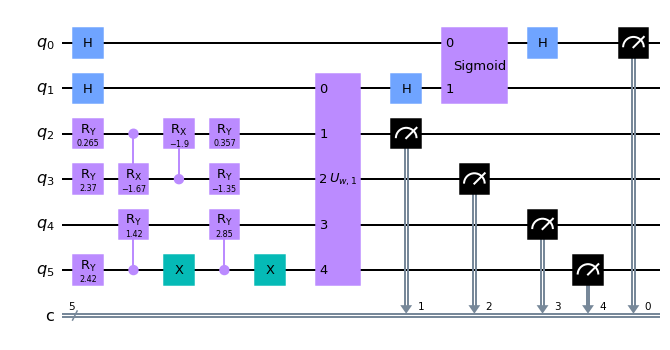

In [18]:
qgen.Building_Gen_Discrim(qgen.thetas, qdiscrim.w).draw('mpl')

## Metrics between ideal measurement and measurement

In [19]:
from numpy import linalg as LA
import qiskit.quantum_info as qi

In [20]:
def density_state(state):
    n = np.shape(state)[0]
    return np.dot(np.real(np.reshape(state,(n,1))),np.real(np.reshape(state,(1,n))))


def one_norm_function(Real, Fake, totalNbQubits):
    """
    Computes the 1 norm between Real and State (as quantum states)
    """
    norm = 0.
    Real1 = [0 for i in range(2**totalNbQubits)]

    for k in range(2**NBQUBITS):
        Real1[NBQUBITS*k] = Real[k]

    Fake1 = [0 for i in range(2**totalNbQubits)]
    
    for k in range(2**NBQUBITS):
        Fake1[NBQUBITS*k] = Fake[k]

    rhoR = np.real(density_state(Real1))
    rhoF = np.real(density_state(Fake1))
    sp,v = LA.eig(rhoR-rhoF)
    
    return np.sum(np.abs(sp))


def kullbackleibler(P,G):
    ## Kullblack-Leibler divergence
    dkl = 0
    
    for i in range(len(P)):
        if  P[i]!=0:
            if G[i] == 0:
                dkl += 100 ## Penalty to avoid infinity
            else:
                dkl += P[i]*np.log(P[i]/G[i])/np.log(2)

    return dkl

# TRAINING

## Training the generator

In [21]:
def trainingGenerator(tr, qdiscrim, qgen, num_shots_DerivThetas, printInfo=False):
    """
    Training the generator
    tr: training class details
    qdiscrim: quantum circuit for the discriminator
    qgen: quantum circuit for the corresponding generator
    num_shots_DerivThetas: number of shots to compute the theta derivatives
    """
        
    fidelity, cost_gen, paths_gen, deriv_gen, DKL, oneNorm = [], [], [], [], [], []

    #T = [i for i in range(tr.epochGen)]

    for i in range(tr.epochGen):
        y = qgen.thetas.copy()
        deriv = [] #local partial derivatives
        
        for l in range(len(qgen.thetas)):
            v = qgen.derivativeGen_theta(l,num_shots_DerivThetas)
            deriv.append(np.abs(v))
            if np.abs(v) >= 8*10**(-3):
                qgen.thetas[l] = qgen.thetas[l] - tr.learning_rate_generator*v
        
        a = qgen.costGen_theta(np.min(num_shots_DerivThetas), qgen.thetas)
        cost_gen.append(a)

        paths_gen.append([qgen.thetas[i] for i in range(len(qgen.thetas))]+[a])
        deriv_gen.append(deriv)
        check = np.array(qgen.state_distribG(tr.shots))
        fidelity.append(np.sum(np.sqrt(check)*np.array(qdiscrim.RealState)))
        kl = kullbackleibler(np.array(qdiscrim.RealState)**2,check)
        
        temp_one_norm = one_norm_function(qdiscrim.RealState, np.sqrt(check), qdiscrim.total)
        
        if printInfo:
            print("Training Generator Epoch ", i+1, "/", tr.epochGen, "||", 
              "1-Norm: ", np.round(temp_one_norm, 3), "||", 
              'Fidelity =', np.round((fidelity[i]**2).real, 3), "||", 
              'Angle =', np.round(np.arccos(fidelity[i])*180/np.pi, 3), "||", 
              'KL =', np.round(kl.real, 3))

        oneNorm.append(temp_one_norm)
        DKL.append(kl)
        
    return cost_gen, deriv_gen, paths_gen, fidelity, DKL, oneNorm

## Training the discriminator

In [22]:
def trainingDiscriminator(tr, qgen, qdiscrim, num_shots_w, printInfo=False):
    """
    Training the discriminator
    tr: training class details
    qdiscrim: quantum circuit for the discriminator
    qgen: quantum circuit for the corresponding generator
    num_shots_w: number of shots to compute the w derivatives
    """

    score_discrim, paths_discrim, deriv_discrim = [], [], []
    
    for i in range(tr.epochDiscrim):
        deriv = [] ## local partial derivatives
        
        for l in range(len(qdiscrim.w)):
            v = qgen.derivativeGen_w(l, num_shots_w)
            
            deriv.append(np.abs(v))

            if np.abs(v)>=5*10**(-3):
                qdiscrim.w[l] = qdiscrim.w[l] + tr.learning_rate_discrim*v
        
        a = qgen.costGen_w(np.min(num_shots_w), qgen.w)
        score_discrim.append(a)

        paths_discrim.append([qdiscrim.w[0],qdiscrim.w[1],qdiscrim.w[2],qdiscrim.w[3],a])
        deriv_discrim.append(deriv)
        
        if printInfo:
            print("Training Discriminator Epoch ", i+1, "/", tr.epochDiscrim, "||", 'Derivatives: ', np.round(deriv,3), "||", 'Score: ', np.round(a,3))
        
    return score_discrim,deriv_discrim,paths_discrim

In [24]:
class Training():
    """
    Class defining all parameters related to the training
    """
    
    def __init__(self):
        self.epochDiscrim = 9 ## number of epochs for the discriminator
        self.epochGen = 1  ## number of epochs for the generator
        self.learning_rate_generator = 0.1 ## learning rate for the generator
        self.learning_rate_discrim = 1 ## learning rate for the discriminator
        self.shots = 2**16  ## For the computation of the fidelity
        self.total_number_epochs = 200 ##  total number of epochs to run the training

**COMMENT ON THE PARAMETERS:**
The discriminator here is a lot less expressive (as an activated inner prod) than the generator. Therefore the number of epochs for the discriminator should be much higher than for the generator.

In [25]:
num_shots_w = [2**12] * qgen.num_qubitsG ## For the generator
num_shots_DerivThetas = [2**12] * len(qgen.thetas) ## For the discriminator

training = Training()

In [26]:
score, derivatives, paths, fidelity, dkl, one_norm = [], [], [], [], [], []
print("**********************************")
for i in range(training.total_number_epochs):
    #print("**********************************")
    
    if (i/10-i//10) == 0.:
        print('Current epoch: ', 1+i, "/", training.total_number_epochs)
    
    trainingDiscrim = trainingDiscriminator(training, qgen, qdiscrim, num_shots_w, False)
    #print("Done training Discriminator")
    
    trainingGen = trainingGenerator(training, qdiscrim, qgen, num_shots_DerivThetas, False)
    #print("Done training Generator")
    
    score += trainingDiscrim[0]
    score += trainingGen[0]
    derivatives += trainingDiscrim[1]
    derivatives += trainingGen[1]
    paths += trainingDiscrim[2]
    paths += trainingGen[2]
    fidelity += trainingGen[3]
    dkl += trainingGen[4]
    
    one_norm += trainingGen[5]
    
    for _ in range(training.epochDiscrim):
        one_norm.append(one_norm[-1])
        dkl.append(dkl[-1])

print("*************************************************************")
print("*********************ALGORITHM COMPLETED*********************")
print("*************************************************************")
        

**********************************
Current epoch:  1 / 200
Current epoch:  11 / 200
Current epoch:  21 / 200
Current epoch:  31 / 200
Current epoch:  41 / 200
Current epoch:  51 / 200
Current epoch:  61 / 200
Current epoch:  71 / 200
Current epoch:  81 / 200
Current epoch:  91 / 200
Current epoch:  101 / 200
Current epoch:  111 / 200
Current epoch:  121 / 200
Current epoch:  131 / 200
Current epoch:  141 / 200
Current epoch:  151 / 200
Current epoch:  161 / 200
Current epoch:  171 / 200
Current epoch:  181 / 200
Current epoch:  191 / 200
*************************************************************
*********************ALGORITHM COMPLETED*********************
*************************************************************


# Plotting the results

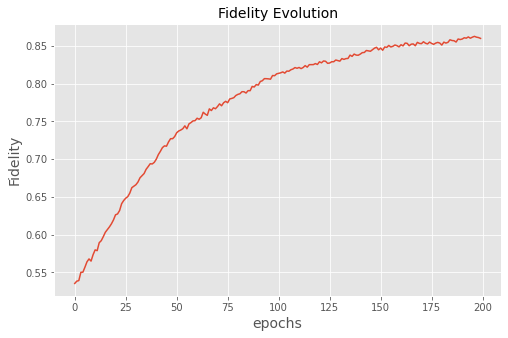

In [27]:
plt.figure(figsize=(8,5))
#plt.plot([i for i in range(len(fidelity))],np.array(fidelity)**2)
plt.plot(range(len(fidelity)),np.array(fidelity)**2)
plt.xlabel('epochs', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.title('Fidelity Evolution', fontsize=14)
plt.show()

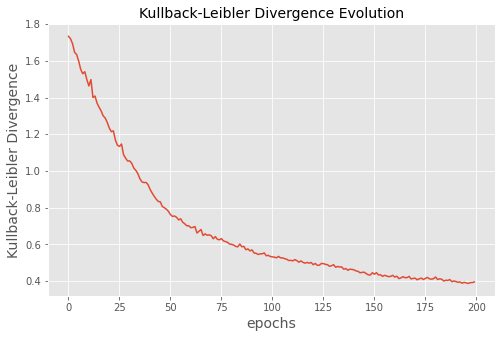

In [28]:
plt.figure(figsize=(8,5))
plt.plot([_ for _ in range(len(dkl)//10)],[dkl[10*i] for i in range(len(dkl)//10)])
plt.xlabel('epochs', fontsize=14)
plt.ylabel('Kullback-Leibler Divergence', fontsize=14)
plt.title('Kullback-Leibler Divergence Evolution', fontsize=14)
plt.show()

C:\Users\ajacquie\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\ajacquie\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


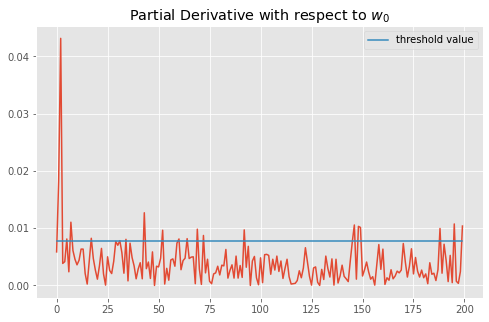

In [29]:
plt.figure(figsize=(8,5))
myXAxis = np.arange(np.shape(derivatives)[0]//10)
plt.plot(myXAxis,np.array([derivatives[10*i][0] for i in range(np.shape(derivatives)[0]//10)]))
plt.plot(myXAxis,np.array([1/2**7 for i in range(np.shape(derivatives)[0]//10)]),label='threshold value')
plt.title('Partial Derivative with respect to $w_{0}$')
plt.legend()
plt.show()

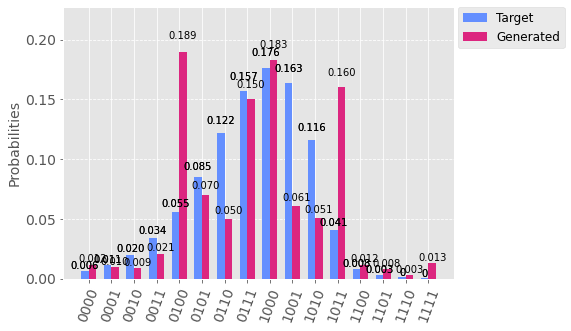

In [30]:
check = np.array(qgen.state_distribG(qgen.shots))
dict_check = {qgen.indexes[i]:np.real(check[i]) for i in range(len(qgen.indexes))}

dict_data = {qgen.indexes[i]:np.real(qdiscrim.RealState[i]**2) for i in range(len(qgen.indexes))}
plot_histogram([dict_data,dict_check],legend=['Target','Generated'])